In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
class SGD:
    """
    Langevin dynamics approximating SGD on a 1D model
    """
    def __init__(self, lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed):
        """
        lr: learning rate
        q: model
        grad_q: gradient of the model
        mxx: expected value of X^2
        vxx: Var(X^2)
        vxy: Var(XY)
        """
        self.lr = lr
        self.q = q
        self.grad_q = grad_q
        self.mxx = mxx
        self.std_xx = std_xx
        self.std_xy = std_xy
        self.w_init = w_init
        self.w = [self.w_init]
        self.state = np.random.RandomState(seed=seed)
        
    def update(self, w_old, d1, d2,a=-1,b=1):
        xi_xx = self.state.normal(self.mxx, self.std_xx)
        xi_xy = self.state.normal(0.0, self.std_xy)
        return w_old - self.lr*(xi_xx * self.q(w_old, d1, d2,a,b) - xi_xy) * self.grad_q(w_old, d1, d2,a,b)
    
    def evolve(self, nstep, d1, d2,a=-1,b=1):
        wc = self.w[-1]
        for _ in range(nstep):
            wc = self.update(wc, d1, d2,a,b)
            self.w.append(wc)

def q(w, d1 ,d2, a=-1, b=1):
    return (w - a)**d1 * (w - b)**d2
    
def grad_q(w, d1, d2, a=-1, b=1):
    return (w-a)**(d1-1) * (w - b)**(d2-1) * (d1 * (w -a) + d2*(w - b))


The local maximum is at -0.3333333333333333 abd the height of the barrier is 1.404663923182442


Text(0, 0.5, 'Potential')

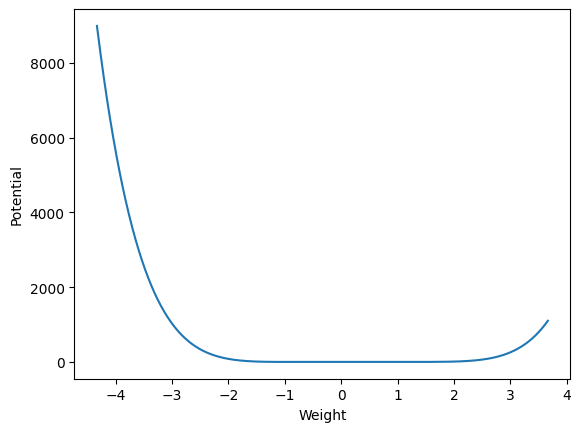

In [115]:
# Run many trajectories of SGD

d1 = 1
d2 = 2
lr = 0.0001
mxx = 1.
std_xx = 1.
std_xy = 1.
num_trajectories = 500
niterations = 5000

# Change a and b to play with the potential barrier
a=-1
b=1.
wmax = (2*a + b)/3
w_minus = wmax - 4
w_plus = wmax + 4
barrier = q(wmax, d1 ,d2, a,b)**2
trajectories = []

print(f"The local maximum is at {wmax} abd the height of the barrier is {barrier}")

for i in range(num_trajectories):
    seed = i
    w_init = np.random.uniform(w_minus, w_plus)
    # maybe seed here?
    L = SGD(lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed)
    L.evolve(niterations, d1, d2,a,b)
    trajectories.append(np.array(L.w).T)

trajectories = np.asarray(trajectories)

# Plot potential

wrange = np.linspace(w_minus, w_plus, 1000)
potential = q(wrange, d1 ,d2, a,b)**2
plt.plot(wrange, potential)
plt.xlabel("Weight")
plt.ylabel("Potential")

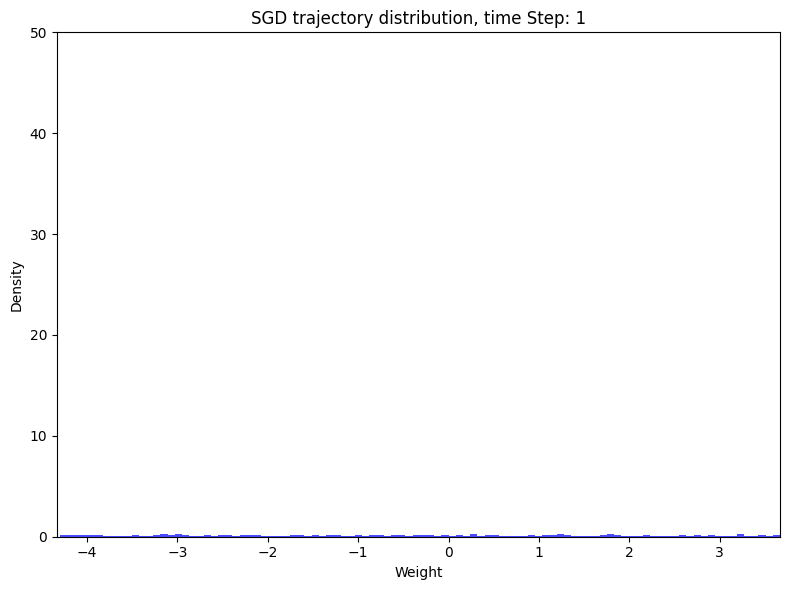

In [96]:
import matplotlib.animation as animation
import seaborn as sns

from IPython.display import HTML
import seaborn as sns

sns.set_style()

# Take a slice of time every 100 steps
nupdate = trajectories.shape[1]
tstep = 100
time_steps = np.arange(0, nupdate, tstep)
trajectories_slice = trajectories[:, time_steps]
n = trajectories_slice.shape[0]
m = trajectories_slice.shape[1]
# Function to update the histogram for each time step
def update_hist(num, data):
    plt.cla()  # clear current axis
    plt.hist(data[:, num], bins=100, density=True, color='blue', alpha=0.7)
    plt.title(f"SGD trajectory distribution, time Step: {num+1}")
    plt.xlabel("Weight")
    plt.ylabel("Density")
    plt.xlim((w_minus,w_plus))
    plt.ylim((0,50))
    plt.tight_layout()

# Create the animation again
fig = plt.figure(figsize=(8, 6))
hist_ani = animation.FuncAnimation(fig, update_hist, frames=m, fargs=(trajectories_slice, ),repeat=False)

# Keep a reference to the animation object
_ = hist_ani

# Embed the animation in the notebook using the to_jshtml method
HTML(hist_ani.to_jshtml())


In [92]:
# Save animation
from pathlib import Path

ani_html = hist_ani.to_jshtml()

current_directory = Path.cwd()
# Define the subdirectory and the filename
subdir = current_directory / "figures"
filename = f"distribution_sgd1d_{num_trajectories}_trajectories_lr_{lr}.html"

# Ensure the subdirectory exists
subdir.mkdir(parents=True, exist_ok=True)

# Write the HTML content to the file in the subdirectory
with (subdir / filename).open("w") as f:
    f.write(ani_html)

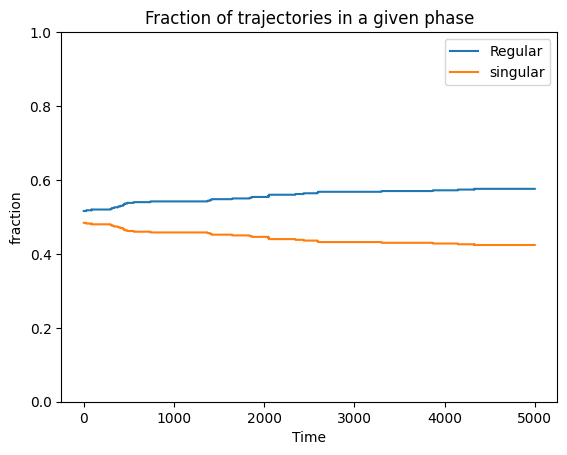

In [116]:
# Compute the fraction of trajectories that fall into the +1 and -1 phase given their initialisation into the +1 and -1 phase

# Run many trajectories and compute fraction of +1 -1 phases

trajectories = np.asarray(trajectories)
phases = np.where(trajectories - wmax > 0, 1, -1)

fraction_regular_phase = np.sum(phases == -1,axis=0)/phases.shape[0]
fraction_singular_phase = np.sum(phases == 1,axis=0)/phases.shape[0]

time = np.arange(0,niterations +1,1)

plt.plot(time, fraction_regular_phase[time], label="Regular")
plt.plot(time, fraction_singular_phase[time], label = "singular")
plt.xlabel("Time")
plt.ylabel("fraction")
plt.title("Fraction of trajectories in a given phase")
plt.ylim((0,1))
plt.legend()

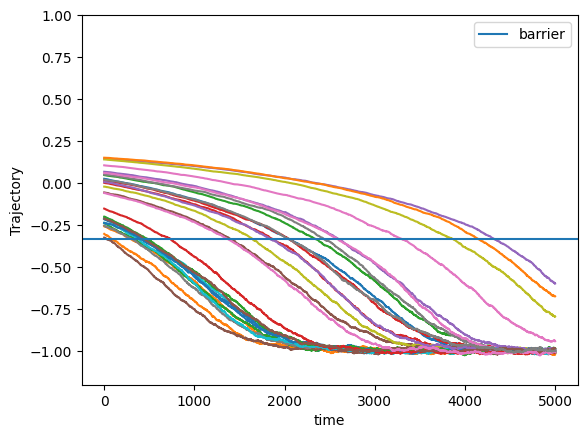

In [117]:
# Find a trajectory that change phase
init_phases = phases[:,0]
# Return the trajectories whose phases change

def phase_change(arr):
    """
    Find all rows where at least one element in that row is different from the corresponding element in the first column.
    
    Parameters:
    - arr (numpy.ndarray): Input 2D array.
    
    Returns:
    - list: Indices of rows that are different from the first column.
    """
    # Comparing each row with the first column
    different_rows = np.any(arr != arr[:, 0].reshape(-1, 1), axis=1)
    
    # Extracting the indices of the rows that are different
    return np.where(different_rows)[0].tolist()

traj_index = phase_change(phases)

traj_change = trajectories[traj_index, :]
for i in range(28):
    plt.plot(time, traj_change[i,:])

plt.ylim((-1.2, 1))
plt.axhline(y=wmax, label="barrier")
plt.xlabel("time")
plt.ylabel("Trajectory")
plt.legend()

(5001,)


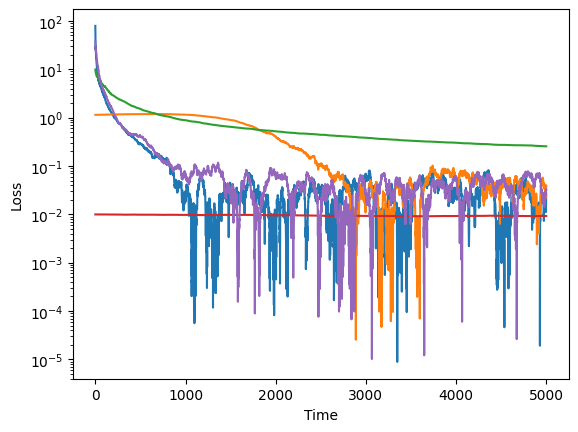

In [129]:
# Loss function of phase change trajectories

running_loss = []

time = np.arange(0,niterations+1,1)

for i in traj_index[15:20]:
    seed = i 
    # Run many trajectories of SGD
    w_init = np.random.uniform(w_minus, w_plus)
    L = SGD(lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed)
    L.evolve(niterations, d1, d2,a,b)
    running_loss.append(np.abs(L.q(np.array(L.w).T, d1, d2,a,b)))

print(running_loss[0].shape)
for j in range(len(running_loss)):
    plt.plot(time, running_loss[j])
    plt.xlabel("Time")
    plt.ylabel("Loss")
    plt.yscale("log")


In [ ]:
# Plot a single trajectory
fig, ax = plt.subplots()
x = np.array(L.w).T
z = np.linspace(0, 1, len(x))
plt.plot(z, x)
plt.xlabel("Iteration")
plt.ylabel("Weight")